# Import Packages

In [1]:
#Import packages
import numpy as np
import torch
# import scipy.interpolate
import math
# from scipy.integrate import quad
from tqdm import trange
import Krylov
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import time
import tikzplotlib as tikz
import os
from IPython.display import clear_output

# Initialise the functions used to generate plots

In [ ]:
#Plot functions
#Plot individual node over time
def plotnode(t,Solutions,filename = "graph_data/nodes.tex"):
    index = 0
    for i in range(len(Solutions[:,0])):
        norm = torch.linalg.vector_norm(Solutions[i,:])
        if norm > torch.linalg.vector_norm(Solutions[index,:]):
            index = i
    plt.plot(t,Solutions[index,:])
    tikz.save(filename)

#Plot pulse
def plotpulse(t,e, filename = "graph_data/pulse.tex"):
    et = torch.zeros((len(t),))
    for i in range (len(t)):
        et[i] = e(t[i])
    plt.plot(t,et)
    tikz.save(filename)

#Contour plot
def Contour(gammaR,gammaI,loss,shifts = [0],randshifts = [0],optshift = [0],filename = "graph_data/sweep.tex"):
    hold = torch.nan_to_num(loss,nan=1e0)
    # if torch.log10(torch.max(hold)) < -2:
    levels = torch.logspace(torch.log10(torch.min(hold)),min(-2,torch.log10(torch.max(hold))),11)
    # else:
    #     levels = torch.logspace(torch.floor(torch.log10(torch.min(hold))),torch.ceil(torch.log10(torch.max(hold))),int(1+torch.ceil(torch.log10(torch.max(hold)))-torch.floor(torch.log10(torch.min(hold)))))
    cont = plt.contour(gammaR,gammaI,loss,levels,norm=LogNorm())
    fmt = '%1.1e'  # Exponential format
    plt.clabel(cont, inline=True, fontsize=8, fmt=fmt, colors='black', manual=False, inline_spacing=3)
    # plt.title("Rayleigh")
    if optshift != [0]:
        marker = ['o','s']
        for i in range(len(optshift)):
            plt.plot(optshift[i].real,optshift[i].imag,marker = marker[i],color = 'k')
    if randshifts != [0]:
        plt.plot(randshifts.real,randshifts.imag,'^',color = [0,0.2,0.8])
    if shifts != [0]:
        col = [1,0.1,0.2]#],[0,0.6,0.1]
        for i in range(len(shifts)):
            plt.plot(shifts[i].real,shifts[i].imag,'x',color = 'r')
            # for j in range (len(shifts[i])+1):
        for i in range(len(shifts)-1):
            plt.arrow(shifts[i].real,shifts[i].imag,shifts[i+1].real - shifts[i].real,shifts[i+1].imag - shifts[i].imag,linestyle = (3,(3,6)),color = 'k',head_length = 0)
    tikz.save(filename)


def ploterror(t,error,ftol = 0,filename = "graph_data/error.tex"):
    plt.plot(t[1:],error)
    plt.yscale('log')
    plt.hlines(ftol,t[0],t[1])
    tikz.save(filename)

def plotshifts(t,shifts,filename = "graph_data/shifts.tex"):
    plt.plot(t[1:],shifts.real)
    plt.plot(t[1:],shifts.imag)
    tikz.save(filename)

def plotenergy(t,Total, filename = "graph_data/energy.tex"):
    # plt.plot(t,Potential)
    # plt.plot(t,Kinetic)
    plt.plot(t,Total)
    tikz.save(filename)

def plotiterations(t,iterations,filename = "graph_data/iterations.tex"):
    plt.plot(t[1:],iterations)
    tikz.save(filename)

def plotoptimisation(t,error,filename = "graph_data/t0opt.tex"):
    plt.plot(t[1:],error)
    plt.yscale('log')
    tikz.save(filename)

def plotobservable(t,obs,filename = "graph_data/observable.tex"):
    plt.plot(t,obs)
    tikz.save(filename)

def plot_graph(adj_matrix: torch.Tensor, node_vector: torch.Tensor, num_clusters=10, clim=None, pos=None, ax=None): 
    # Convert adjacency matrix to a NetworkX graph
    G = nx.from_numpy_array(adj_matrix.cpu().numpy())
    if ax == None:
        fig,ax = plt.subplots(figsize=(10, 10))
    # Define cluster positions if not provided
    if pos is None:
        cluster_positions = np.array([
            (np.exp(1j * 2 * math.pi * i / num_clusters).real, 
             np.exp(1j * 2 * math.pi * i / num_clusters).imag) 
            for i in range(num_clusters)
        ]) * 5.0
        pos = {}

        nodes_per_cluster = len(node_vector) // num_clusters
        for i in range(num_clusters):
            cluster_center = cluster_positions[i]
            nodes = range(i * nodes_per_cluster, (i + 1) * nodes_per_cluster)
            for node in nodes:
                pos[node] = cluster_center + np.random.randn(2) * 0.5  # Small perturbation

        # Use spring_layout with initial positions
        pos = nx.spring_layout(G, pos=pos, fixed=pos.keys(), seed=42)

    elif pos is True:
        with open(directory + "pos" + str(num_clusters) + "clusters.pkl", "rb") as f:
            pos = pickle.load(f)

    # Set node colors
    node_colors = node_vector

    # Define colormap and color limits
    cmp = plt.cm.viridis
    if clim is None:
        clim = [torch.min(node_colors) + 1e-4, torch.max(node_colors)]

    # Plot edges
    rows, cols = np.where(adj_matrix.cpu().numpy() != 0)
    weight = torch.abs(adj_matrix[rows, cols])
    nx.draw_networkx_edges(G, pos=pos, width=3 * weight / torch.max(weight), alpha=1, ax=ax)

    # Plot nodes
    nx.draw_networkx_nodes(G, pos=pos, node_size=50 * node_vector, node_color=node_colors, 
                           cmap=cmp, vmin=clim[0], vmax=clim[1], nodelist=list(G.nodes()), ax=ax)

    # Add cluster labels
    if num_clusters == 10:
        textcoords = [[-1.05, 0.1], [1.05, -0.3], [0.3, 1], [-0.2, 1], [-1, -0.5], 
                      [1, 0.4], [-0.8, 0.8], [0.8, -0.8], [-0.5, -0.9], [0.1, -1.1]]
        for i in range(num_clusters):
            r = 7
            ax.text(r * np.exp(2j * math.pi * i / 10).real, 
                    r * np.exp(2j * math.pi * i / 10).imag, 
                    str(i + 1), fontsize=20, ha='center', va='center')


def plotnorm(t,nrm,filename = "graph_data/norm.tex"):
    nrmerr = torch.zeros((len(t)-1,))
    for i in range(1,len(t)):
        nrmerr[i-1] = torch.abs(nrm[0]-nrm[i])
    plt.plot(t[1:],nrmerr)
    plt.yscale('log')
    tikz.save(filename)

# Define the function for the time-dependent pulse

The time-dependent pulse $\eta_1(t)$ is given in equation (4.9) by
$$
    \eta_1(t) =
\begin{cases}
    0, & \text{for } t<1.6,\quad 4\leq t<4.8,\quad 7.2\leq t, \\
    \frac{1}{4}, &\text{for } 1.6 \leq t < 2.4, \quad 3.2 \leq t < 4 ,\\
    -\frac{1}{4}, &\text{for } 4.8\leq t <5.6,\quad 6.4\leq t < 7.2 ,\\
    \frac{1}{2}, &\text{for } 2.4 \leq t < 3.2 ,\; \mathrm{and}\\
    -\frac{1}{2}, &\text{for } 5.6 \leq t < 6.4 .
\end{cases}
$$

In [3]:
#time-dependent pulse
import bisect

# def e(tau):
#     a = 1
#     sigma = t[-1]/5
#     alpha = t[-1]/2
#     omega = 5e-2*(1000/t[-1])
#     return a*np.exp(-((tau-alpha)**4)/(2*sigma**4))*np.sin(omega*tau)

def e(tau):
    a = np.array([0,0,1,2,1,0,-1,-2,-1,0])/4
    # stepst = torch.tensor((torch.arange(1,11)*n/10),dtype = torch.int)*dt
    stepst = np.array(np.arange(1,10)*n/10,dtype=np.int8)*dt
    i = bisect.bisect_right(stepst,tau) 
    return a[i]

    

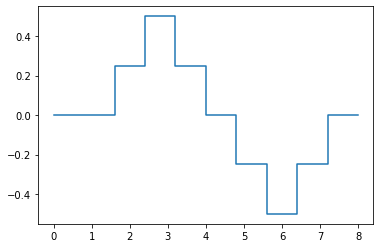

In [8]:
#Plot the pulse
d = 1e-6
newt = [0,20*dt-d,20*dt+d,30*dt-d,30*dt+d,40*dt-d,40*dt+d,50*dt-d,50*dt+d,60*dt-d,60*dt+d,70*dt-d,70*dt+d,80*dt-d,80*dt+d,90*dt-d,90*dt+d,100*dt]
plotpulse(newt,e)

# Initialise variables for the Schrodinger problem

Here we generate:
- the time step $\tau$
- the number of grid points $N$
- the number of time steps $n$
- the time grid $t$
- the Krylov subspace dimension $m$
- the time-independent graph matrices $A_1$ and $A_2$
- the initial vector $v = u_0$

In [4]:
#Functions that generate graphs and initial condition
def randblock(N):
    H = torch.zeros((N,N),dtype = torch.complex128)
    H1 = torch.rand((N-1,N-1),dtype = torch.float64)*10-5
    T = H1 - torch.transpose(H1,0,1)
    H[0:N-1,0:N-1] = T
    for i in range (N-1):
        H[i,-1] += -torch.sum(T[i,:])
        H[-1,i] += -torch.sum(T[:,i])
    return H

# def D1(N):
#     wraps = torch.zeros((N,N))
#     wraps[0,-1] = -1
#     wraps[-1,0] = 1
#     return (wraps + torch.diag(-torch.ones((N-1,)),-1) + torch.diag(torch.ones((N-1,)),1))/(2*dx)

# def D3(N):
#     wraps = torch.zeros((N,N))
#     wraps[0,-1] = 2
#     wraps[0,-2] = -1
#     wraps[-1,0] = -2
#     wraps[-2,0] = 1
#     wraps[1,-1] = -1
#     wraps[-1,1] = 1
#     return (wraps + torch.diag(-torch.ones((N-2,)),-2) + torch.diag(2*torch.ones((N-1,)),-1) - torch.diag(2*torch.ones((N-1,)),1) + torch.diag(torch.ones((N-2,)),2))/(2*dx**3)

# def loop(N):
#     conn = torch.rand((N-1,))
#     wraps = torch.zeros((N,N))
#     wraps[-1,0] = torch.sum(conn)
#     wraps[0,-1] = -torch.sum(conn)
#     return torch.diag(conn,1) - torch.diag(conn,-1) + wraps

# def block(N):
#     return D1(N) + 1e-1*D3(N) + 1e-1*randblock(N)#loop(N)

def sparse(N,sparsity = 0.9999):
    S = torch.zeros((N,N),dtype = torch.float64)
    randvals = torch.rand(math.floor((1-sparsity)*(N**2)),dtype = torch.float64)#*10-2
    indx = torch.randperm(N**2)
    for i in range (len(randvals)):
        S[int(torch.floor(indx[i]/N)),int(indx[i]%N)] = randvals[i]
    S = S - torch.transpose(S,0,1)
    return S

def Ham(N,NBlock = 100):
    H = torch.zeros((N,N),dtype = torch.complex128)
    BD = torch.zeros((N,N),dtype = torch.complex128)
    B = torch.zeros((N,NBlock),dtype = torch.complex128)
    for i in range (int(N/NBlock)):
        blk = randblock(NBlock)
        B[i*NBlock:(i+1)*NBlock,:] = blk
        BD[i*NBlock:(i+1)*NBlock,i*NBlock:(i+1)*NBlock] = blk
    S = sparse(N)
    H = S + BD
    return H,BD,B


def c(i):
    sigma1 = 20
    sigma2 = 1
    i0 = 5
    # wide = math.exp((-1*(i-i0)**2)/(2*sigma1**2))
    dist = torch.distributions.uniform.Uniform(0,1e-4)
    wide = dist.sample()
    narrow = math.exp((-1*(i-i0)**2)/(2*sigma2**2))
    return narrow + wide

def init(A0,A1,dx,dt):
    N = len(A0)
    L,V = torch.linalg.eig(A0)
    sort, index = torch.sort(L.imag)
    L = L[index]
    V = V[:,index]
    v1 = torch.zeros((N,),dtype = torch.complex128)
    for i in range (N):
        v1 += c(i)*V[:,i]
    v2 = V[:,5]
    dist = torch.distributions.uniform.Uniform(0,1e-4)
    for i in range (len(L)):
        v2 += dist.sample()*V[:,i]
    # v3 = torch.matrix_exp(200*(A0+e(35*dt)*A1)) @ v2
    v = v2
    return v.real/Krylov.L2.Norm(v.real,dx).to(torch.complex128)#,v2/Krylov.L2.Norm(v2,dx).to(torch.complex128),v3/Krylov.L2.Norm(v3,dx).to(torch.complex128)

### Generate, save, or load the variables

In [ ]:
#Generate variables.
dt = 8e-2
N = 1000 # spatial dimension size
dx = 1/N
n = 100 # number of time steps
t = torch.linspace(0,n*dt,n+1) # time vector
m = 20 # Krylov subspace dimension
A1,BD1,B1 = Ham(N,int(N/10)) # Generate random graph and block diagonal
# rand = torch.rand((N,N),dtype = torch.float64) - 1/2 # Generate matrix with random elements in U(-1/2,1/2)
# rand = rand + rand.T
# A2 = A1 * rand # Generate random graph as random change in elements of A1
A2,BD2,B2 = Ham(N,int(N/10))
# BD2 = BD1 * rand # Generate Block-diagonal of A2
# M0 = magnus(A1,A2,t[0],dt)
# Me = magnus(A1,A2,t[40],dt)
v = init(A1,A2,dx,dt) # Generate initial condition
directory = "graph_data/"

In [6]:
#Save variables
vars = {'A1':A1,
        'A2':A2,
        'BD1':BD1,
        'BD2':BD2,
        'v':v,
        'dt':dt,
        'dx':dx,
        'n':n,
        't':t,
        'm':m,
        'N':N}
with open(directory+"Variables.pkl",'wb') as f:
    pickle.dump(vars,f)
# torch.save(A1,"graph_data/A1.pt")
# torch.save(A2,"graph_data/A2.pt")
# torch.save(BD1,"graph_data/BD1.pt")
# torch.save(BD2,"graph_data/BD2.pt")
# torch.save(v,"graph_data/v.pt")
# torch.save(dt,"graph_data/dt.pt")
# torch.save(n,"graph_data/timestep_no.pt")
# torch.save(N,"graph_data/N.pt")
# torch.save(t,"graph_data/t.pt")
# torch.save(m,"graph_data/m.pt")

In [5]:
#Load variables
directory = "graph_data/"
with open(directory+"Variables.pkl",'rb') as f:
    vars = pickle.load(f)
A1 = vars['A1']
A2 = vars['A2']
BD1 = vars['BD1']
BD2 = vars['BD2']
v = vars['v']
dt = vars['dt']
dx = vars['dx']
n = vars['n']
t = vars['t']
m = vars['m']
N = vars['N']
# A1=torch.load("graph_data/A1.pt")
# A2=torch.load("graph_data/A2.pt")
# BD1=torch.load("graph_data/BD1.pt")
# BD2=torch.load("graph_data/BD2.pt")
# v=torch.load("graph_data/v.pt")
# dt=torch.load("graph_data/dt.pt")
# n=torch.load("graph_data/timestep_no.pt")
# N=torch.load("graph_data/N.pt")
# t=torch.load("graph_data/t.pt")
# m=torch.load("graph_data/m.pt")

# Define functions which compute the local and global errors as well as the observables.

The global error at time $t_{k+1}$ is given by equation (4.4) in the paper
$$
\|\mathcal{L}(t_{k+1})\| = \|\hat{v}(t_{k+1}) - \tilde{v}(t_{k+1})\|,
$$
where $\hat{v}(t_{k+1})$ is the multi-step approximation to the solution of the Schrodinger equation, and $\tilde{v}(t_{k+1})$ is the multi-step reference solution. The initial vector is $v = u_0$.

In [6]:
#Define global error function
def compute_GE(refs,sols,dx):
    #Initialise vector containing local error over time
    GE = torch.zeros((len(refs[0,:])-1,),dtype = torch.float64)
    #Compute ratio of number of time steps
    N1 = len(refs[0,:])-1
    N2 = len(sols[0,:])-1
    dt_factor = int(N2/N1)
    #Compute L2 norm of the error vectors
    for i in range(1,len(refs[0,:])):
        GE[i-1] = Krylov.L2.Error(refs[:,i],sols[:,dt_factor*i],dx)
    return GE

The local error at time $t_{k+1}$ is given by equation (4.3) in the paper
$$
\|\mathcal{L}(\tau)\| = \|\hat{v}(\tau) - \tilde{v}(\tau)\|,
$$
where $\hat{v}(\tau)$ is the single-step approximation to the solution of the Schrodinger equation with time step $\tau = t_{k+1}-t_k$, and $\tilde{v}(\tau)$ is the single-step reference solution. The initial vector is $v = \hat{v}(t_k)$, the approximate solution at time $t_k$, and exponent matrix is $A=A(t_k)$.

In [7]:
#Define local error function
def compute_LE(t,sols,dx):
    #Initialise vector containing local error over time
    LE = torch.zeros((len(t)-1,),dtype = torch.float64)
    # Record time at start
    t0 = time.time()
    #Compute local errors
    for i in range(len(t)-1):
        #Compute reference solution at next time step
        M = dt*(A1+e(t[i])*A2)
        ref = Krylov.prop.Pade_propagator(M,sols[:,i])
        #Compute L2 norm of the error vector
        LE[i] = Krylov.L2.Error(ref,sols[:,i+1],dx)
        #Record time after i+1 iterations
        t1 = time.time()
        #Compute estimated time to complete
        eta = (t1-t0)*(t[-1] - t[i])/t[i+1]
        #Print progress
        print('t = {0:<4.2f} - eta {1:>02d}:{2:>02d}:{3:>02d}'.format(t[i],math.floor(eta/(60**2)),math.floor((eta%(60**2))/60),math.floor(eta%60)),end='\r')
    return LE

The observables are calculated by the inner product given in equation (4.10). We denote the energy by $E$. The observables at time $t_k$ are give by
$$
E(t_k) = (\hat{v}(t_k),\tau A_1\hat{v}(t_k)), \quad \|\hat{v}(t_k)\| = \sqrt{ (\hat{v}(t_k),\hat{v}(t_k))}
$$
where $\hat{v}(\tau)$ is the single-step approximation to the solution of the Schrodinger equation with time step $\tau = t_{k+1}-t_k$with initial vector is $v = \hat{v}(t_k)$, the approximate solution at time $t_k$.

In [ ]:
def compute_NRG(sols,dx):
    #Initialise vectors to store energy
    n = len(sols[0,:])
    NRG = torch.zeros((n,),dtype = torch.complex128)
    nrm = torch.zeros((n,),dtype = torch.float64)
    for i in range(len(sols[0,:])):
        NRG[i] = Krylov.L2.IP(sols[:,i],dt*A1  @ sols[:,i],1)
        nrm[i] = Krylov.L2.Norm(sols[:,i],1).real
    return nrm,NRG

# Compute reference solution by brute force
The reference solution is computed by time-stepping the Pade method built in to torch.matrix_exp().

### Generate the reference solution using expm

In [ ]:
#Compute reference solution
def compute_ref(t,dt,v):
    #Initialise list of solutions
    sols = torch.zeros((len(v),len(t)),dtype = v.dtype)
    sols[:,0] = v
    #Record start time of integration
    t0 = time.time()
    #Begin time integration
    for i in range(len(t)-1):
        #Compute Hamiltonian at time t[i]
        M = dt*(A1+e(t[i])*A2)
        #Compute solution at next time step by Pade
        sols[:,i+1] = Krylov.prop.Pade_propagator(M,sols[:,i])
        #Record time after i+1 time steps
        t1 = time.time()
        #Compute estimated time to complete
        eta = (len(t)-i-2)*(t1-t0)/(i+1)
        #Print progress
        print('t = {0:<4.2f} - eta {1:>02d}:{2:>02d}:{3:>02d}'.format(t[i+1],math.floor(eta/(60**2)),math.floor((eta%(60**2))/60),math.floor(eta%60)),end='\r')
    return sols
glo_ref = compute_ref(t,dt,v)
tau = torch.linspace(1.52,1.68,1001)
glo_ref = compute_ref(tau,tau[1]-tau[0],glo_ref[:,19])
torch.save(glo_ref,directory+"animation_frames.pt")

### Save and load the reference solution

In [ ]:
#Save reference solution
torch.save(glo_ref,directory+"reference.pt")

In [9]:
#Load reference solution
glo_ref = torch.load(directory+"reference.pt")

# Compute the polynomial Krylov approximation
The polynomial Krylov approximation is computed by time stepping using the approximation equation (2.2) in the paper,
$$
\mathrm{e}^{\tau A}v \approx \beta V_m \mathrm{e}^{\tau H_m}e_1.
$$
Here $beta = \|v\|$, and $V_m$ and $H_m$ are obtained through the Arnoldi algorithm (1) with $X = A$.

### Generate the polynomial Krylov approximation with time step of dt/dt_factor

In [ ]:
#Compute polynomial Krylov approximation
def compute_polyK(t,v,m,dx):
    #Compute new time grid
    # new_t = torch.linspace(t[0],t[-1],dt_factor*(len(t)-1)+1)
    #Initialise list of solutions
    sols = torch.zeros((len(v),len(t)),dtype = v.dtype)
    sols[:,0] = v
    #Record start time of integration
    t0 = time.time()
    #Begin time integration
    for i in range(len(t)-1):
        #Compute Hamiltonian at time t[i]
        M = (t[1]-t[0])*(A1+e(t[i])*A2)
        #Compute solution at next time step by polynomial Krylov
        sols[:,i+1] = Krylov.prop.PolyK_propagator(M,sols[:,i],m,dx)
        #Record time after i+1 time steps
        t1 = time.time()
        #Compute estimated time to complete
        eta = (t1-t0)*(t[-1] - t[i+1])/t[i+1]
        #Print progress
        print('t = {0:<4.2f} - eta {1:>02d}:{2:>02d}:{3:>02d}'.format(t[i+1],math.floor(eta/(60**2)),math.floor((eta%(60**2))/60),math.floor(eta%60)),end='\r')
    return sols
#Define the factor to decrease the time step size
dt_factor = 1
newt = torch.linspace(t[0],t[-1],dt_factor*n + 1)
#Compute the solution
poly_sols = compute_polyK(newt,v,m,dx)

### Save and load the polynomial Krylov approximation

In [ ]:
#save the results
torch.save(poly_sols,directory+"polyK_sols_dtby"+str(dt_factor)+".pt")

In [ ]:
#Load polynomial Krylov approximation
dt_factor = 1
poly_sols = torch.load(directory+"polyK_sols_dtby"+str(dt_factor)+".pt")

### Compute and plot the polynomial Krylov global error

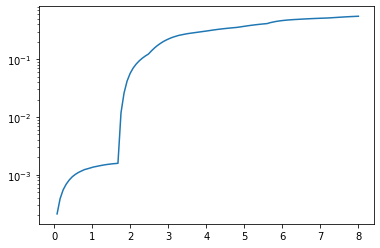

In [ ]:
#plot polynomial Krylov global error
glo_ref = compute_ref(newt,newt[1]-newt[0],v)
PGE = compute_GE(glo_ref,poly_sols,dx)
torch.save(PGE,directory+"poly_GE_dtby"+str(dt_factor)+".pt")
ploterror(newt,PGE,filename = directory+"poly_GE_dtby"+str(dt_factor)+".tex")

# Compute the shift-and-invert Krylov approximation
The shift-and-invert Krylov approximation is computed by time stepping using the approximation equation (2.6) (for the shift-inverted approach proptype = "SI") or equation (2.7) (for the Rayleigh approach proptype "RQ") in the paper,
$$
\mathrm{e}^{\tau A}v \approx \beta V_m \mathrm{e}^{\tau A_m}e_1.
$$
Here $beta = \|v\|$, and $A_m$ is defined as equation (2.5)
$$
A_m = H_m^{-1} + \alpha I
$$
for the shift-inverted approach. For the Rayleigh approach $A_m$ is given by equation (2.10) if $A$ is not skew-Hermitian
$$
A_m = (H_{m}^{-1} + \alpha I) - h_{m+1,m} (V_m, A v_{m+1}) e_m^\top H_{m}^{-1},
$$
or equation (2.15) if $A$ is skew-Hermitian
$$
A_m = (H_{m}^{-1} + \alpha I) + h_{m+1,m}^2 (\kappa + \overline{\alpha}) y_m y_m\mathsf{H}, \quad \kappa = \left( v_{m+1},Av_{m+1} \right), \ y_m\mathsf{H} = \boldsymbol{e}_m^\top H_{m}^{-1}
$$
$V_m, H_m,v_{m+1}$ and $h_{m+1,m}$ are obtained through the Arnoldi algorithm (1) with $X = (A-\alpha I)^{-1}$.

The shifts are computed by minimising equation (3.8) for the shift-inverted approach, $\alpha^* = \argmin_\alpha{\int_0^\tau\|\mathcal{R}_{SI}(s)\|\,\mathrm{d}s}$,
$$
\int_0^\tau\|\mathcal{R}_{SI}(s)\|\,\mathrm{d}s
= \beta h_{m+1,m} \|(A - \alpha I) v_{m+1}\| \int_0^\tau |e_m^\top H_m^{-1} \mathrm{e}^{s S_m} e_1| \,\mathrm{d}s.
$$
by minimising equation (3.11) for the Rayleigh approach when $A$ is not skew-Hermitian, $\alpha^* = \argmin_\alpha{\int_0^\tau\|\mathcal{R}_{RA}(s)\|\,\mathrm{d}s}$
$$
\int_0^\tau\|\mathcal{R}_{RA}(s)\|\,\mathrm{d}s
= \beta h_{m+1,m} \|(A - \alpha I)v_{m+1} - V_m(V_m,Av_{m+1})\| \int_0^\tau |y_m\mathsf{H} \mathrm{e}^{s A_m} e_1| \,\mathrm{d}s,
$$
or by minimising equation (3.13a) for the Rayleigh approach when $A$ is skew-Hermitian, $\alpha^* = \argmin_\alpha{\int_0^\tau\|\mathcal{R}_{RA}(s)\|\,\mathrm{d}s}$
$$
\int_0^\tau\|\mathcal{R}_{RA}(s)\|\,\mathrm{d}s
= \beta h_{m+1,m} \chi
 \int_0^\tau |y_m^\mathsf{H} \mathrm{e}^{s A_m} e_1| \,\mathrm{d}s,
$$

$$
\chi = \left(\|(A - \alpha I) v_{m+1}\|^2 -(h_{m+1,m}|\kappa + \overline{\alpha}| \|y_m\|_2)^2\right)^{1/2}.
$$

### Define function to execute the time integration using the shift-invert Krylov method

In [11]:
#Function to time step shift-and-invert Krylov solution
def compute_SIK(t,dt,v,m,dx,proptype,opttype,surrogate,maxiter,ftol,shift=None):
    #Initialise list of solutions
    sols = torch.zeros((len(v),len(t)),dtype = v.dtype)
    sols[:,0] = v
    #Initialise variables to store shifts, number of iterations, and objective function value over time
    shifts = torch.zeros((len(t)-1,),dtype = torch.complex128)
    iters = torch.zeros((len(t)-1,),dtype = torch.int64)
    objective = torch.zeros((len(t)-1,),dtype = torch.float64)
    #Record start time of integration
    t0 = time.time()
    #Initialise first guess for shift
    if os.path.isfile(directory+"initial_shift.pt"):
        x0flt = torch.load(directory+"initial_shift.pt")
        x0 = [x0flt.real,x0flt.imag]
        x0 = [47.8,-0.1]
    else:
        x0 = None
    # x0 = [71,-5]
    #Begin time integration
    for i in range(len(t)-1):
        #Record time after i+1 time steps
        t1 = time.time()
        #Compute estimated time to complete
        eta = (t1-t0)*(t[-1] - t[i])/t[i+1]
        #Print progress
        print('t = {0:<4.2f} - eta {1:>02d}:{2:>02d}:{3:>02d}'.format(t[i],math.floor(eta/(60**2)),math.floor((eta%(60**2))/60),math.floor(eta%60)),end='\n')
        #Compute true Hamiltonian at time t[i]
        M = dt*(A1+e(t[i])*A2)
        #Compute surrogate Hamiltonian at time t[i]
        if surrogate == True:
            Ms = dt*(BD1-e(t[i])*BD2) # with surrogate
        else:
            Ms = dt*(A1+e(t[i])*A2) # without surrogate
        #Compute solution at next time step by Pade
        sols[:,i+1],opt_data = Krylov.prop.SIK_propagator(true_A = M,
                                                true_v = sols[:,i],
                                                true_dx = dx,
                                                surrogate_A = Ms,
                                                surrogate_v = sols[:,i],
                                                surrogate_dx = dx,
                                                m = m,
                                                proptype = proptype,
                                                opttype = proptype+'_'+opttype,
                                                maxiter=maxiter,
                                                ftol=ftol,
                                                opt_bounds=[(0,100),(-50,50)],
                                                x0=x0,
                                                shift = shift)
        #Save random initial guesses for shift as well as best initial guess
        if x0==None and i==0 and shift == None:
            torch.save(opt_data['random_shifts'],directory+"random_shifts.pt")
            torch.save(opt_data['shifts'][0],directory+"initial_shift.pt")
        #Use best shift as initial guess for the next time step
        x0 = [opt_data['shifts'][-1].real,opt_data['shifts'][-1].imag]
        #Record shifts, number of iterations and objective function value
        shifts[i] = opt_data['shifts'][-1]
        if shift == None:
            iters[i] = len(opt_data['shifts'])-1
            objective[i] = opt_data['objective'][-1]
        #Clear outputs
        time.sleep(.01)
        clear_output(wait=True)
    #Collect optimiser data into a dict
    optimiser_data = {'shifts':shifts,
                      'iterations':iters,
                      'objective':objective}
    return sols, optimiser_data

### Generate the shift-and-invert Krylov approximation

In [ ]:
#Compute shift-invert Krylov solutions
import winsound
proptype = "RQ"
opttype = "defect"
surrogate = True
ftol = 2e-4
maxiter = 100
# SIK_sols, optimiser_data = compute_SIK(t,dt,v,m,dx,proptype,opttype,surrogate,maxiter=maxiter,ftol = ftol)
SIK_sols, optimiser_data = compute_SIK(t,dt,v,m,dx,proptype,opttype,surrogate,maxiter=maxiter,ftol = ftol,shift = 49.42-0.00j)
opttype = "NoOpt"

winsound.PlaySound("SystemHand", winsound.SND_ALIAS)

t = 7.92 - eta 00:00:00


### Save and load shift-invert Krylov data

In [ ]:
#Save outputs
torch.save(SIK_sols,directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_sols_"+opttype+".pt")
with open(directory+"surrogate_"+str(surrogate)+"/"+proptype+"/optimiser_data_"+opttype+".pkl",'wb') as f:
    pickle.dump(optimiser_data,f)

In [10]:
#Load shift-invert Krylov data
proptype = "RQ"
opttype = "defect"
surrogate = False
SIK_sols = torch.load(directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_sols_"+opttype+".pt")
with open(directory+"surrogate_"+str(surrogate)+"/"+proptype+"/optimiser_data_"+opttype+".pkl",'rb') as f:
    optimiser_data = pickle.load(f)

## Generate plots

### Plot defect integral

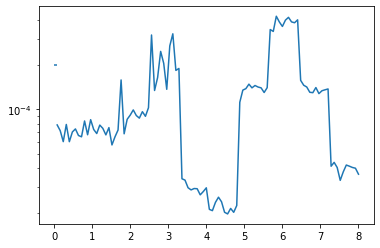

In [53]:
ploterror(t,optimiser_data['objective'],ftol = ftol,filename = directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_DI_"+opttype+".tex")

### Plot local error

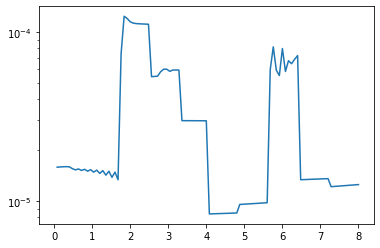

In [55]:
SILE = compute_LE(t,SIK_sols,dx)
torch.save(SILE,directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_LE_"+opttype+".pt")
ploterror(t,SILE,filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_LE_"+opttype+".tex")

### Plot global error

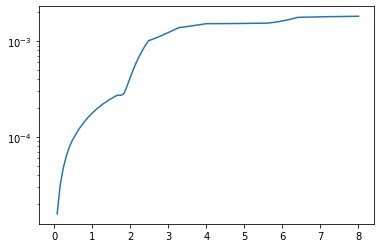

In [54]:
#global error
SIGE = compute_GE(glo_ref,SIK_sols,dx)
# opttype = "constantshift"
torch.save(SIGE,directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_GE_"+opttype+".pt")
ploterror(t,SIGE,filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_GE_"+opttype+".tex")

### Plot the number of optimisation iterations

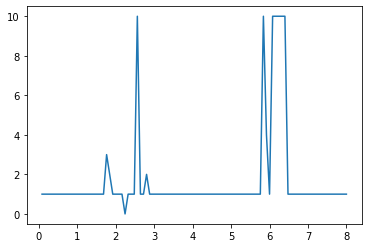

In [41]:
plotiterations(t,optimiser_data['iterations'],filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_iters_"+opttype+".tex")

### Plot shifts

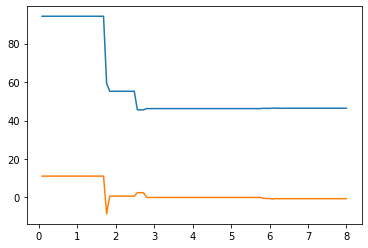

In [42]:
plotshifts(t,optimiser_data['shifts'],filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_shifts_"+opttype+".tex")

### Plot the change in the norm

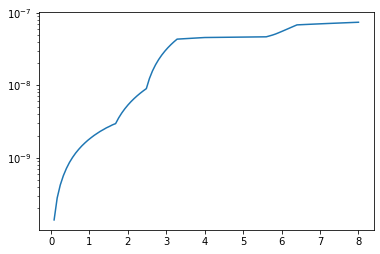

In [17]:
SInrm = compute_NRG(SIK_sols,dx)[0]
torch.save(SInrm,directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_norm_"+opttype+".pt")
plotnorm(t,SInrm,filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_norm_"+opttype+".tex")


### Plot energy

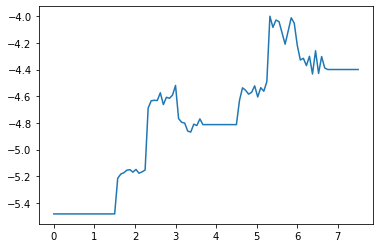

In [42]:
SINRG = compute_NRG(glo_ref,dx)[1]
torch.save(SINRG,directory+"surrogate_"+str(surrogate)+"/"+proptype+"/SIK_NRG_"+opttype+".pt")
plotobservable(t,SINRG.imag,filename = directory + "surrogate_"+str(surrogate)+"/"+proptype+"/SIK_NRG_"+opttype+".tex")


### Plot graph

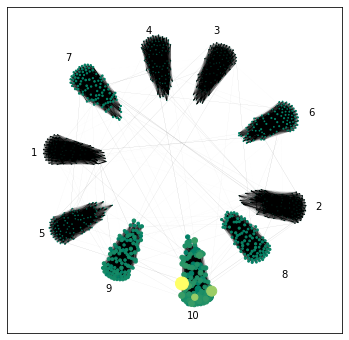

In [19]:
i = 0
M = dt*(A1 + e(t[i])*A2)
# M = torch.ones((len(A1),len(A1)))
u = torch.abs(SIK_sols[:,i])#SIK_sols[:,i]
# u = torch.zeros((len(M),),dtype = torch.float64)
# for i in range(10):
#     u[100*i:100*(i+1)] = i/10
# u[100*(i+1):100*(i+2)] = 2
plotgraph(M,torch.abs(v))

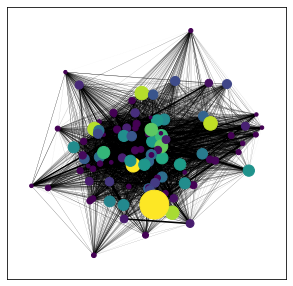

In [15]:
cluster = 5
i = 0
M = dt*(A1 + e(t[i])*A2)
# M = torch.ones((len(A1),len(A1)))
u = torch.abs(SIK_sols[:,i])#SIK_sols[:,i]

M1 = M[cluster*100:(cluster+1)*100,cluster*100:(cluster+1)*100]
u1 = u[cluster*100:(cluster+1)*100]
# u = torch.zeros((len(M),),dtype = torch.float64)
# for i in range(10):
#     u[100*i:100*(i+1)] = i/10
# u[100*(i+1):100*(i+2)] = 2
u1srt = torch.sort(u1)[0]
clim = [1,u1srt[-2]]
plot_graph(M1.to(torch.float64), u1, num_clusters=1, pos = True, clim = clim)
# plot_graph(M.to(torch.float64),u)

# Generate contour plot of the true loss or defect plotted against the shift

In [12]:
#Parameter sweep over a given range
def Sweep(gammaR,gammaI,H,v,dt,dx,m,loss_fn):
    loss = torch.zeros((len(gammaI),len(gammaR)))
    # Ref = Krylov.Solution.Exact(H,v,dt,torch.matrix_exp)
    for i in range (len(gammaI)):
        for j in range (len(gammaR)):
            print('[{0:^3d},{1:^3d}]'.format(i,j),end='\r')
            # gamma = gammaR[j] + 1j*gammaI[i]
            # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(H,v,m,gamma,dx,"Shift Invert")
            loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],loss_fn)
            # if loss_fn == "defect":
            #     loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],"defect")
            #     # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(H,v,m,gamma,dx,"Shift Invert")
            #     # Vm = Vm[:,0:-1]
            #     # Hm = Hm[0:-1,0:-1]
            #     # Am = gamma*torch.eye(len(Hm)) - torch.linalg.inv(Hm)
            #     # loss[i,j] = Krylov.Solution.defect(H,Vm,Am,beta,dt,dx,m)
            # elif loss_fn == "l2":
            #     # gamma = gammaR[j] + 1j*gammaI[i]
            #     # X = torch.linalg.inv(H - gamma*torch.eye(len(v)))
            #     # Vm,Hm,beta = Krylov.Arnoldi.Polynomial(X,v,m,gamma,dx,"Polynomial")
            #     # Am = Krylov.Solution.Rayleigh_Quotient(H,Vm,Hm,gamma,dx)
            #     # REst = Krylov.Solution.Polynomial(Vm[:,0:-1],Am,dt,beta,torch.matrix_exp)
            #     # loss[i,j] = Krylov.L2.Error(REst,Ref,dx)
            #     loss[i,j] = Krylov.Optimise.loss(H,v,dt,dx,m,[gammaR[j],gammaI[i]],"l2")
    return loss



In [17]:
i = 21
x0flt = optimiser_data['shifts'][i-1]
M = dt*(A1 + e(t[i])*A2)
proptype = "RQ"
opttype = "defect"
maxiter = 10
ftol = 2e-4
x0 = [x0flt.real,x0flt.imag]
est,opt_data = Krylov.prop.SIK_propagator(true_A = M,
                                        true_v = SIK_sols[:,i],
                                        true_dx = dx,
                                        surrogate_A = M,
                                        surrogate_v = SIK_sols[:,i],
                                        surrogate_dx = dx,
                                        m = m,
                                        proptype = proptype,
                                        opttype = proptype+'_'+opttype,
                                        maxiter=maxiter,
                                        ftol=ftol,
                                        opt_bounds=[(0,100),(-50,50)],
                                        x0=x0,
                                        shift = None)

    iteration    0 - shift =  94.24+11.10j loss =  4.52e-03
    iteration    1 - shift =  94.24+11.10j loss =  4.52e-03
    iteration    2 - shift =  66.31-12.24j loss =  3.81e-04
    iteration    3 - shift =  58.64-6.77j loss =  9.10e-05


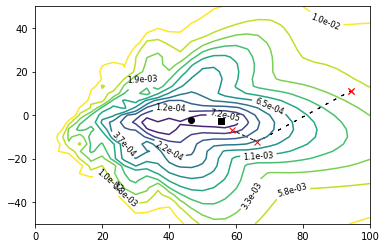

In [21]:
# v = G + R
gammaR = torch.linspace(0,100,31)
gammaI = torch.linspace(-50,50,31)
loss_fn = "RQ_defect"
# loss_fn = "l2"
optshift = [46.50-2.23j,55.38-2.57j]
loss = Sweep(gammaR,gammaI,M,SIK_sols[:,i],1,dx,m,loss_fn)
torch.save(loss,"graph_data/"+str(loss_fn)+"_sweep_t="+str(i)+".pt")
Contour(gammaR,gammaI,loss,shifts = opt_data['shifts'], optshift=optshift, filename = "graph_data/"+str(loss_fn)+"_sweep_t="+str(i)+".tex")